In [45]:
import sys
import pickle
import nltk
from nltk.stem import PorterStemmer
import torch.nn.functional as F
import torch
import torch.nn as nn
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import torch
nltk.download('punkt')
from gensim.models import Word2Vec
from nltk.tokenize import word_tokenize
sys.path.insert(0, '..')
from nltk.tokenize import word_tokenize
ps = PorterStemmer()
from collections import Counter

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\gxb18167\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [46]:
with open('EEG_Text_Pairs.pkl', 'rb') as file:
    EEG_word_level_embeddings = pickle.load(file)
    train_data = pickle.load(file)

In [47]:
with open('Target_Pred_Strings.pickle', 'rb') as f:
    data = pickle.load(f)

In [48]:
target_string_list = data['Target_String']

In [49]:
predicted_string_list = data['Predicted_String']

In [50]:
def get_word_classifcation_count(target_string_list, predicted_string_list, train_data, stemming=True, strict=False):
    Correct_Predictions = {}
    Incorrect_Predictions = {}
    counter_list = []

    train_string = " ".join(train_data)
    train_string_tokenized = word_tokenize(train_string)

    if stemming == True:
        train_string_tokenized_stemmed = []
        for w in train_string_tokenized:
            train_string_tokenized_stemmed.append(ps.stem(w))
    else:
        train_string_tokenized_stemmed = []
        for w in train_string_tokenized:
            train_string_tokenized_stemmed.append(w)



    for i in range(len(target_string_list)):
        target_string = target_string_list[i]
        predicted_string = predicted_string_list[i]

        predicted_string = predicted_string[0:len(target_string)]

        target_tokenized = word_tokenize(target_string)

        #print(target_tokenized)
        predicted_tokenized = word_tokenize(predicted_string)

        if stemming == True:
            target_tokenized_stemmed = []
            predicted_tokenized_stemmed = []
            for w in target_tokenized:
                target_tokenized_stemmed.append(ps.stem(w))
                counter_list.append(ps.stem(w))
            for w in predicted_tokenized:
                predicted_tokenized_stemmed.append(ps.stem(w))
        else:
            target_tokenized_stemmed = []
            predicted_tokenized_stemmed = []
            for w in target_tokenized:
                target_tokenized_stemmed.append(w)
                counter_list.append(w)
            for w in predicted_tokenized:
                predicted_tokenized_stemmed.append(w)

        if strict == False:
            for word in target_tokenized_stemmed:
                if word in predicted_tokenized_stemmed:
                    if word in Correct_Predictions:
                        Correct_Predictions[word] += 1
                    else:
                        Correct_Predictions[word] = 1
                else:
                    if word in Incorrect_Predictions:
                        Incorrect_Predictions[word] += 1
                    else:
                        Incorrect_Predictions[word] = 1
        else:
            min_length = min(len(predicted_tokenized_stemmed), len(target_tokenized_stemmed))
            for i in range(min_length):
                if target_tokenized_stemmed[i] == predicted_tokenized_stemmed[i]:
                    word = target_tokenized_stemmed[i]
                    if word in Correct_Predictions:
                        Correct_Predictions[word] += 1
                    else:
                        Correct_Predictions[word] = 1
                else:
                    word = target_tokenized_stemmed[i]
                    if word in Incorrect_Predictions:
                        Incorrect_Predictions[word] += 1
                    else:
                        Incorrect_Predictions[word] = 1



    target_word_counter = Counter(counter_list)
    print(len(target_word_counter))
    word_frequency = Counter(train_string_tokenized_stemmed)
    print(len(word_frequency))

    common_keys = set(target_word_counter.keys()) & set(word_frequency.keys())
    word_frequency = {k: word_frequency[k] for k in common_keys}



    return Correct_Predictions, Incorrect_Predictions, word_frequency


In [14]:
Correct_Predictions, Incorrect_Predictions, word_frequency = get_word_classifcation_count(target_string_list, predicted_string_list, train_data, stemming=True, strict=True)

873
4027


In [78]:
import re


def calculate_tf(sentences):
    term_frequencies = []

    for sentence in sentences:
        # Preprocess the sentence: convert to lowercase and remove non-alphanumeric characters
        preprocessed_sentence = re.sub(r"[^a-zA-Z0-9\s]", "", sentence.lower())

        # Tokenize the sentence into words
        words = preprocessed_sentence.split()

        # Calculate term frequency using Counter
        term_frequency = Counter(words)

        # Normalize term frequency by dividing by the total number of terms in the sentence
        total_terms = len(words)
        normalized_tf = {term: frequency / total_terms for term, frequency in term_frequency.items()}

        term_frequencies.append(normalized_tf)

    return term_frequencies

In [79]:
tf= calculate_tf(target_string_list)

In [80]:
tf

[{'the': 0.058823529411764705,
  'venezuelans': 0.058823529411764705,
  'say': 0.058823529411764705,
  'things': 0.058823529411764705,
  'like': 0.058823529411764705,
  'si': 0.058823529411764705,
  'pretty': 0.058823529411764705,
  'much': 0.058823529411764705,
  'and': 0.058823529411764705,
  'por': 0.058823529411764705,
  'favor': 0.058823529411764705,
  'go': 0.058823529411764705,
  'home': 0.058823529411764705,
  'when': 0.058823529411764705,
  'talking': 0.058823529411764705,
  'to': 0.058823529411764705,
  'americans': 0.058823529411764705},
 {'if': 0.058823529411764705,
  'you': 0.058823529411764705,
  'already': 0.058823529411764705,
  'like': 0.058823529411764705,
  'this': 0.11764705882352941,
  'sort': 0.11764705882352941,
  'of': 0.11764705882352941,
  'thing': 0.11764705882352941,
  'is': 0.058823529411764705,
  'that': 0.058823529411764705,
  'all': 0.058823529411764705,
  'over': 0.058823529411764705,
  'again': 0.058823529411764705},
 {'an': 0.07692307692307693,
  'awf

In [81]:
import math


def calculate_idf(sentences):
    # Preprocess each sentence and tokenize into words
    preprocessed_sentences = [re.sub(r"[^a-zA-Z0-9\s]", "", sentence.lower()).split() for sentence in sentences]

    # Flatten the list of words to get unique terms
    unique_terms = set([term for words in preprocessed_sentences for term in words])

    # Calculate document frequency for each term
    doc_frequencies = Counter()
    for term in unique_terms:
        for words in preprocessed_sentences:
            if term in words:
                doc_frequencies[term] += 1

    # Calculate IDF for each term
    total_documents = len(sentences)
    idf_results = {term: math.log(total_documents / (1 + doc_frequency)) for term, doc_frequency in doc_frequencies.items()}

    return idf_results

In [85]:
def calculate_tf_idf(sentences):
    # Calculate TF for each term in each sentence
    def calculate_tf(sentence):
        words = re.sub(r"[^a-zA-Z0-9\s]", "", sentence.lower()).split()
        term_frequency = Counter(words)
        total_terms = len(words)
        normalized_tf = {term: frequency / total_terms for term, frequency in term_frequency.items()}
        return normalized_tf

    # Calculate IDF for each term across all sentences
    def calculate_idf(sentences):
        preprocessed_sentences = [re.sub(r"[^a-zA-Z0-9\s]", "", sentence.lower()).split() for sentence in sentences]
        unique_terms = set([term for words in preprocessed_sentences for term in words])
        doc_frequencies = Counter()
        for term in unique_terms:
            for words in preprocessed_sentences:
                if term in words:
                    doc_frequencies[term] += 1
        total_documents = len(sentences)
        idf_results = {term: math.log(total_documents / (1 + doc_frequency)) for term, doc_frequency in doc_frequencies.items()}
        return idf_results

    # Calculate TF-IDF for each term in each sentence
    tf_idf_results = []
    idf_results = calculate_idf(sentences)
    for sentence in sentences:
        tf = calculate_tf(sentence)
        tf_idf = {term: tf_value * idf_results[term] for term, tf_value in tf.items()}
        tf_idf_results.append(tf_idf)

    return tf_idf_results

In [82]:
idf = calculate_idf(target_string_list)

In [86]:
tf_idf = calculate_tf_idf(target_string_list)

In [89]:
tf_idf

[{'the': 0.029909613814834132,
  'venezuelans': 0.28017798180162584,
  'say': 0.2422257766743229,
  'things': 0.2422257766743229,
  'like': 0.1666338143364891,
  'si': 0.28017798180162584,
  'pretty': 0.2422257766743229,
  'much': 0.20149904294351664,
  'and': 0.05274605215850337,
  'por': 0.28017798180162584,
  'favor': 0.23949354271488332,
  'go': 0.28017798180162584,
  'home': 0.28017798180162584,
  'when': 0.17582627796362302,
  'talking': 0.28017798180162584,
  'to': 0.0754894466121562,
  'americans': 0.28017798180162584},
 {'if': 0.23949354271488332,
  'you': 0.23949354271488332,
  'already': 0.28017798180162584,
  'like': 0.1666338143364891,
  'this': 0.35912076721531666,
  'sort': 0.5603559636032517,
  'of': 0.09442195740032695,
  'thing': 0.5603559636032517,
  'is': 0.09340419567884839,
  'that': 0.11463704610121517,
  'all': 0.20011598089165059,
  'over': 0.21934616404280208,
  'again': 0.21934616404280208},
 {'an': 0.1462372152906856,
  'awful': 0.36638659158674153,
  'movie

In [28]:
import matplotlib.pyplot as plt
# Extract data for plotting

# Define the frequency threshold
frequency_threshold = 50000

# Filter words based on frequency threshold
filtered_words = [word for word, freq in word_frequency.items() if freq < frequency_threshold]
filtered_frequencies = [word_frequency[word] for word in filtered_words]
filtered_classifications = [Correct_Predictions.get(word, 0) for word in filtered_words]

# Create a scatter plot
plt.scatter(filtered_frequencies, filtered_classifications, color='blue', alpha=0.5)

# Customize the plot
plt.title('Word Frequency vs Correct Classification (Below {} Frequency)'.format(frequency_threshold))
plt.xlabel('Word Frequency')
plt.ylabel('Correct Classification')
plt.grid(True)
plt.show()

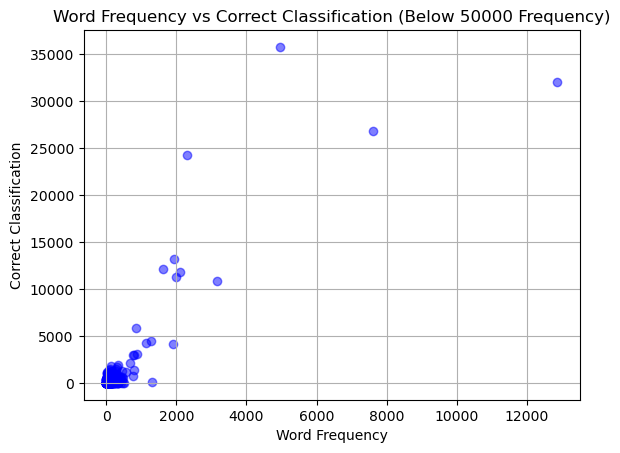

In [29]:
import matplotlib.pyplot as plt

# Extract data for plotting

# Define the frequency threshold
frequency_threshold = 50000

# Filter words based on frequency threshold
filtered_words = [word for word, freq in word_frequency.items() if freq < frequency_threshold]
filtered_frequencies = [word_frequency[word] for word in filtered_words]
filtered_correct_classifications = [Correct_Predictions.get(word, 0) for word in filtered_words]
filtered_incorrect_classifications = [Incorrect_Predictions.get(word, 0) for word in filtered_words]

# Create scatter plots for correct and incorrect predictions
plt.scatter(filtered_frequencies, filtered_correct_classifications, color='blue', alpha=0.5, label='Correct Predictions')
plt.scatter(filtered_frequencies, filtered_incorrect_classifications, color='red', alpha=0.5, label='Incorrect Predictions')

# Customize the plot
plt.title('Word Frequency vs Classification (Below {} Frequency)'.format(frequency_threshold))
plt.xlabel('Word Frequency')
plt.ylabel('Classification')
plt.legend()  # Display legend to distinguish between correct and incorrect predictions
plt.grid(True)
plt.show()

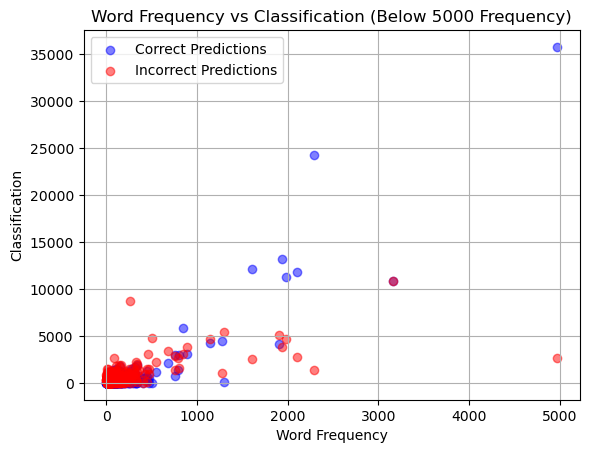

In [32]:
import matplotlib.pyplot as plt

# Extract data for plotting

# Define the frequency threshold
frequency_threshold = 50000

# Filter words based on frequency threshold
filtered_words = [word for word, freq in word_frequency.items() if freq < frequency_threshold]
filtered_frequencies = [word_frequency[word] for word in filtered_words]
filtered_correct_classifications = [Correct_Predictions.get(word, 0) for word in filtered_words]
filtered_incorrect_classifications = [Incorrect_Predictions.get(word, 0) for word in filtered_words]

# Create figure and axes
fig, ax1 = plt.subplots()

# Plot correct predictions on the left y-axis
ax1.scatter(filtered_frequencies, filtered_correct_classifications, color='blue', alpha=0.5, label='Correct Predictions')
ax1.set_xlabel('Word Frequency')
ax1.set_ylabel('Correct Classification', color='blue')
ax1.tick_params('y', colors='blue')

# Create a secondary y-axis for incorrect predictions on the right
ax2 = ax1.twinx()
ax2.scatter(filtered_frequencies, filtered_incorrect_classifications, color='red', alpha=0.5, label='Incorrect Predictions')
ax2.set_ylabel('Incorrect Classification', color='red')
ax2.tick_params('y', colors='red')

# Customize the plot
plt.title('Word Frequency vs Classification (Below {} Frequency)'.format(frequency_threshold))
plt.grid(True)
fig.tight_layout()
plt.show()


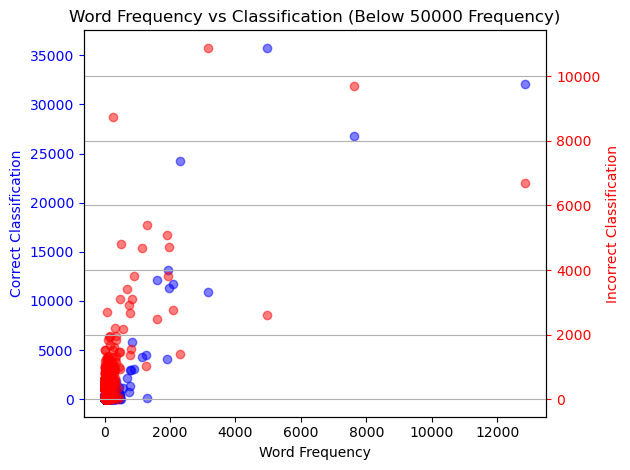